In [48]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import regionmask

In [2]:
data = xr.open_dataset("./data/nsidc_iceage.1984_2020.7daily.nc")

In [4]:
iceage = data.age_of_sea_ice[0,:,:]

In [46]:
lat = data['latitude']
lon = data['longitude']

In [66]:
Arctic_basins = regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50

In [91]:
sorted(Arctic_basins.names)

['Adriatic Sea',
 'Aegean Sea',
 'Amazon River',
 'Amundsen Gulf',
 'Amundsen Sea',
 'Andaman Sea',
 'Arabian Sea',
 'Arafura Sea',
 'Arctic Ocean',
 'Baffin Bay',
 'Bahía de Campeche',
 'Balearic Sea',
 'Baltic Sea',
 'Banda Sea',
 'Barents Sea',
 'Bay of Bengal',
 'Bay of Biscay',
 'Bay of Fundy',
 'Bay of Plenty',
 'Beaufort Sea',
 'Bellingshausen Sea',
 'Bering Sea',
 'Bismarck Sea',
 'Black Sea',
 'Bo Hai',
 'Bristol Bay',
 'Bristol Channel',
 'Caribbean Sea',
 'Caspian Sea',
 'Celebes Sea',
 'Ceram Sea',
 'Chesapeake Bay',
 'Chukchi Sea',
 'Columbia River',
 'Cook Inlet',
 'Coral Sea',
 'Davis Strait',
 'Drake Passage',
 'East China Sea',
 'English Channel',
 'Golfe du Lion',
 'Golfo San Jorge',
 'Golfo de California',
 'Golfo de Panamá',
 'Great Australian Bight',
 'Great Barrier Reef',
 'Greenland Sea',
 'Gulf of Aden',
 'Gulf of Alaska',
 'Gulf of Bothnia',
 'Gulf of Carpentaria',
 'Gulf of Finland',
 'Gulf of Guinea',
 'Gulf of Honduras',
 'Gulf of Kutch',
 'Gulf of Maine',
 

In [51]:
mask = Arctic_basins.mask(lon,lat)

D:\application\Anaconda\envs\academic\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [70]:
Lap = Arctic_basins[['Laptev Sea']]

<GeoAxesSubplot: >

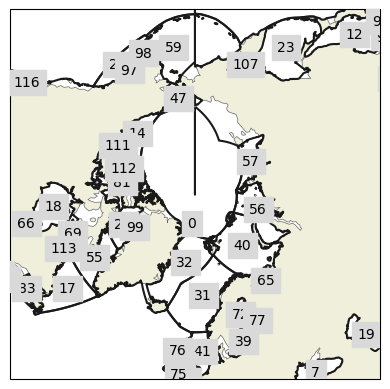

In [89]:
ax = plt.axes(projection=proj)
ax.add_feature(cfeature.LAND)
ax.set_extent([-180,180,50,90],crs=ccrs.PlateCarree())
Arctic_basins.plot()